In [ ]:
import torch
import torch.nn as nn

In [ ]:
from torchsummary import summary

In [ ]:
!pip install torchviz graphviz



In [ ]:
from torchviz import make_dot

from IPython.display import Image

In [ ]:
!pip install torchview

In [ ]:
from torchview import draw_graph

In [ ]:
import graphviz
graphviz.set_jupyter_format('png')


'svg'

# Esercise 1

In [ ]:


class InceptionModule(nn.Module):
    def __init__(self, in_channels_first_layer):
        super(InceptionModule, self).__init__()
        self.conv_a = nn.Conv2d(in_channels=in_channels_first_layer, out_channels=64, kernel_size=1, padding=0)
        self.conv_b1 = nn.Conv2d(in_channels=in_channels_first_layer, out_channels=16, kernel_size=1, padding=0)
        self.conv_b2 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3, padding=1)
        self.conv_c1 = nn.Conv2d(in_channels=in_channels_first_layer, out_channels=16, kernel_size=1, padding=0)
        self.conv_c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.maxpool_d = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv_d = nn.Conv2d(in_channels=in_channels_first_layer, out_channels=32, kernel_size=1, padding=0)

    def forward(self, x):
        x_a = self.conv_a(x)

        x_b = self.conv_b1(x)
        x_b = self.conv_b2(x_b)

        x_c = self.conv_c1(x)
        x_c = self.conv_c2(x_c)

        x_d = self.maxpool_d(x)
        x_d = self.conv_d(x_d)

        y = torch.cat((x_a, x_b, x_c, x_d), dim=1)  # Concatenate along the channels dimension
        return y



In [ ]:
import torch
from torchsummary import summary

# Create a dummy input tensor similar to the shape in Keras
dummy_input = torch.randn(1, 192, 28, 28)  # Batch size 1, channels 192, height 28, width 28

# Instantiate the InceptionModule
inception = InceptionModule(192)

# Pass the dummy input through the module
output = inception(dummy_input)

# Print the shape of the output
print(output.shape)  # This should print: torch.Size([1, 256, 28, 28])

# Display the model summary
summary(inception, input_size=(192, 28, 28))


torch.Size([1, 256, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          12,352
            Conv2d-2           [-1, 16, 28, 28]           3,088
            Conv2d-3          [-1, 128, 28, 28]          18,560
            Conv2d-4           [-1, 16, 28, 28]           3,088
            Conv2d-5           [-1, 32, 28, 28]          12,832
         MaxPool2d-6          [-1, 192, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           6,176
Total params: 56,096
Trainable params: 56,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.87
Params size (MB): 0.21
Estimated Total Size (MB): 3.66
----------------------------------------------------------------


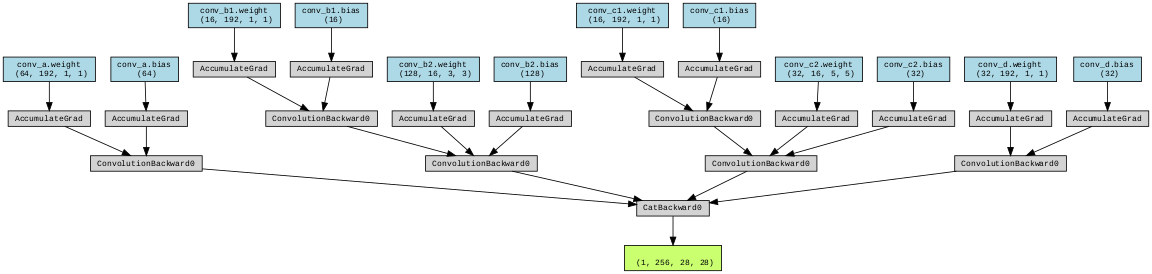

In [ ]:
graph = make_dot(output, params=dict(inception.named_parameters()))
graph.render('inception_module', format='png')  # Save the visualization as 'inception_module.png'


# Display the image in Colab
Image('inception_module.png')


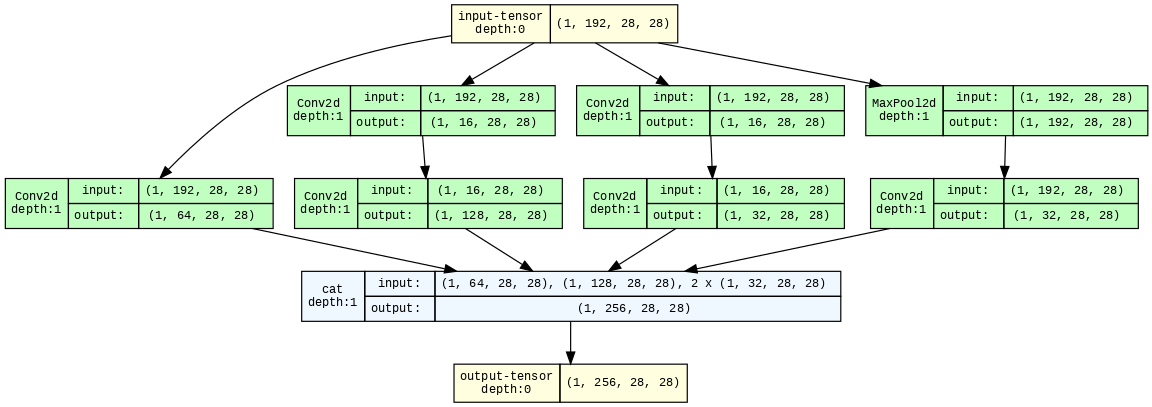

In [ ]:
model_graph = draw_graph(inception, input_size=(1, 192, 28, 28), device='meta')
model_graph.visual_graph

#Esercise 2



In [ ]:
# define size of the input layer

length = 30         #seconds
sampling_rate = 200 #Hz


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IdentityBlock(nn.Module):
    def __init__(self, n_in, n_out,  subsample=1):
        super(IdentityBlock, self).__init__()

        self.bn1 = nn.BatchNorm1d(n_in)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.1)
        self.conv1 = nn.Conv1d(n_in, n_out, kernel_size=16, padding='same')

        self.bn2 = nn.BatchNorm1d(n_out)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv1d(n_out, n_out, kernel_size=16, padding='same')

        self.maxpool = nn.MaxPool1d(subsample)

    def forward(self, x):
        shortcut = x.clone()

        x = self.bn1(x)
        x = self.relu1(x)
        x = self.do1(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = self.relu2(x)
        x = self.do2(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        shortcut = self.maxpool(shortcut)

        x += shortcut

        return x

class FirstIdentityBlock(nn.Module):
    def __init__(self, n_in, n_out):
        super(FirstIdentityBlock, self).__init__()

        self.conv1 = nn.Conv1d(n_in, n_out, kernel_size=16, padding='same')

        self.bn2 = nn.BatchNorm1d(n_out)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv1d(n_out, n_out, kernel_size=16, padding='same')

        self.maxpool = nn.MaxPool1d(2)

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)

        x = self.bn2(x)
        x = self.relu2(x)
        x = self.do2(x)
        x = self.conv2(x)
        x=self.maxpool(x)

        shortcut = self.maxpool(shortcut)

        x += shortcut

        return x


In [ ]:
class YourModel(nn.Module):
    def __init__(self, n_samples):
        super(YourModel, self).__init__()

        self.conv1 = nn.Conv1d(n_samples, 64, kernel_size=16)
        self.bn2_block1 = nn.BatchNorm1d(64)
        self.relu2_block1 = nn.ReLU()

        self.first_identity_block = FirstIdentityBlock(64, 64)

        self.identity_blocks = nn.ModuleList()
        for i in range(7):
            self.identity_blocks.append(IdentityBlock(64, 64, subsample=2))
            self.identity_blocks.append(IdentityBlock(64, 64, subsample=1))

        self.identity_blocks.append(IdentityBlock(64,64, subsample=1))

        self.bn_final = nn.BatchNorm1d(64)
        self.relu_final = nn.ReLU(inplace=True)
        self.fc_final = nn.Linear(64, 512)
        self.pred_layer = nn.Linear(512, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn2_block1(x)
        x = self.relu2_block1(x)

        x = self.first_identity_block(x)

        for block in self.identity_blocks:
            x = block(x)

        x = self.bn_final(x)
        x = self.relu_final(x)
        x = torch.transpose(x,1,2)   #produce a distribution over the 14 output classes for each time-step
                                     #transpose the feature map so that the last column is the feature

        x = self.fc_final(x)
        x = self.pred_layer(x)
        pred = F.softmax(x, dim=1)

        return x

# Instantiate your model
model = YourModel(1)


In [ ]:
print(model)

YourModel(
  (conv1): Conv1d(1, 64, kernel_size=(16,), stride=(1,))
  (bn2_block1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_block1): ReLU()
  (first_identity_block): FirstIdentityBlock(
    (conv1): Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (do2): Dropout(p=0.1, inplace=False)
    (conv2): Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=same)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (identity_blocks): ModuleList(
    (0): IdentityBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.1, inplace=False)
      (conv1): Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=same)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  ret = func(*args, **kwargs)


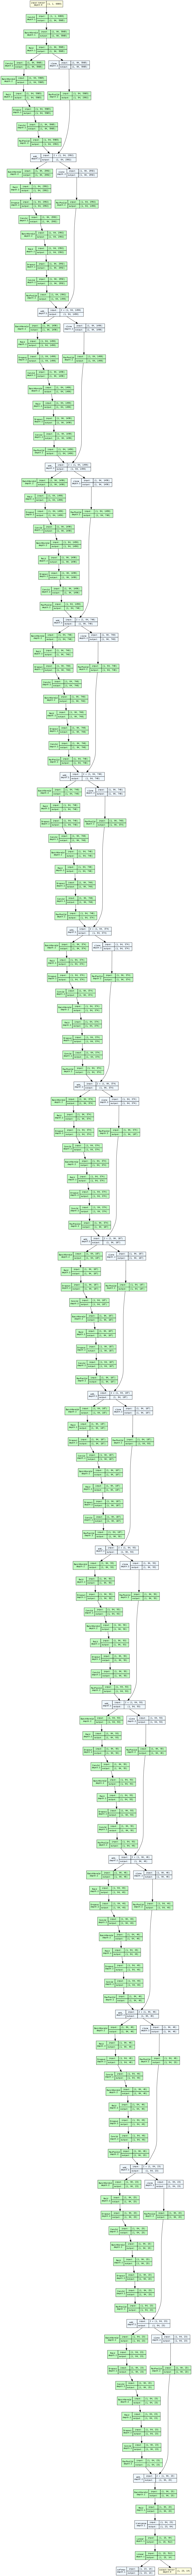

In [ ]:
model_graph = draw_graph(model, input_size=(1, 1,6000), device='meta')
model_graph.visual_graph

#Exercise 3

In [ ]:


# Specify the value of L
L = 2


In [ ]:
class Backbone(nn.Module):
    def __init__(self, n_input=3, dropout_rate=0.1, num_classes=100):
        super(Backbone, self).__init__()

        self.conv1 = nn.Conv2d(n_input, 96, kernel_size=7, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(96)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc6 = nn.Linear(4608, 4096)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc7 = nn.Linear(4096, 2048)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc8 = nn.Linear(2048, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.bn1(self.relu(self.conv1(x))))
        x = self.pool2(self.bn2(self.relu(self.conv2(x))))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dropout1(self.relu(self.fc6(x)))
        x = self.dropout2(self.relu(self.fc7(x)))
        y = self.softmax(self.fc8(x))
        return y

In [ ]:
# Use the model
dropout_rate = 0.1
num_classes = 100
model_backbone  = Backbone(dropout_rate=dropout_rate, num_classes=num_classes)
model_backbone2 = Backbone(2*L, dropout_rate=dropout_rate, num_classes=num_classes)
print(model_backbone)
print(model_backbone2)

Backbone(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc6): Linear(in_features=4608, out_features=4096, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc7): Linear(in_features=4096, out_features=2048, bias=True)
  (drop

In [ ]:
class TwoStream(nn.Module):
    def __init__(self,L=2, dropout_rate=0.1, num_classes=100):
        super(TwoStream, self).__init__()

        self.model_backbone  = Backbone(dropout_rate=dropout_rate, num_classes=num_classes)
        self.model_backbone2 = Backbone(2*L, dropout_rate=dropout_rate, num_classes=num_classes)

    def forward(self, x_img, x_optical_flow):
        pred_img = self.model_backbone(x_img)
        pred_of = self.model_backbone2(x_optical_flow)

        return (pred_img + pred_of) / 2.0

In [ ]:
# Define the input images
x_img = torch.empty(1, 3, 224, 224)  # Adapt the shape according to the image dimensions
x_optical_flow = torch.empty(1, 2 * L, 224, 224)  # Adapt the shape according to the optical flow dimensions

twostream_model = TwoStream()

print(twostream_model)

TwoStream(
  (model_backbone): Backbone(
    (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc6): Linear(in_features=4608, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (fc7): L

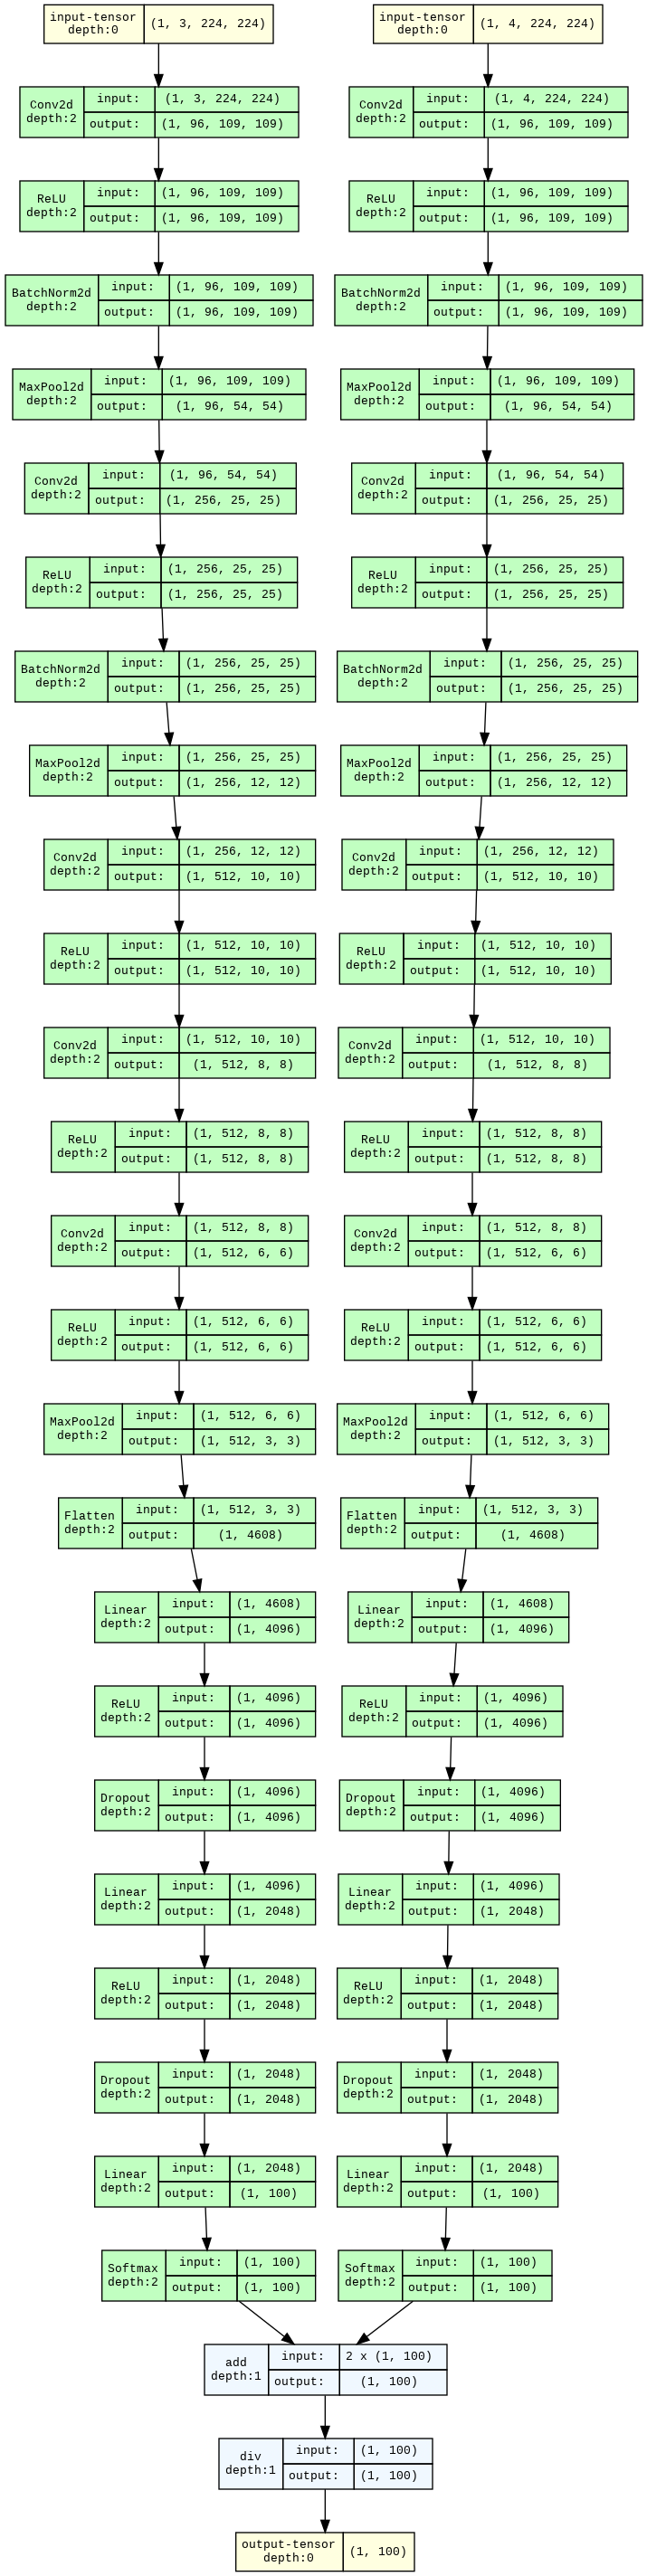

In [ ]:
model_graph = draw_graph(twostream_model, [x_img, x_optical_flow])
model_graph.visual_graph

#Exercise 4

Train a regression model that starting from the following categorical data

*   Number of bedrooms
*   Number of bathrooms
*   Area (i.e., square footage)
*   Zip code

and a total of four images:

*   Bedroom
*   Bathroom
*   Kitchen
*   Frontal view of the house

For the purpose of this exercise, we will assume that all images are uploaded


Credits: Adapted from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Definition of the MLP module
#create the MLP module
#use a flag to include or not the final regression layer, so that the model can be used by itself
# or in combination with other input
class MLP(nn.Module):
    def __init__(self, dim, regress=False):
        super(MLP, self).__init__()
        # First linear layer with ReLU activation
        self.layer1 = nn.Linear(dim, 8)
        # Second linear layer with ReLU activation
        self.layer2 = nn.Linear(8, 4)
        # Final regression layer, if required
        self.regress_layer = None
        if regress:
            self.regress_layer = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        if self.regress_layer:
            x = self.regress_layer(x)
        return x

# Definition of the CNN module
class CNN(nn.Module):
    def __init__(self, input_channels, regress=False):
        super(CNN, self).__init__()
        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        # Modify the first convolutional layer to adapt to the number of input channels
        vgg16.features[0] = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        # Define the structure of the model's backbone
        self.backbone = nn.Sequential(*list(vgg16.features.children())[:-1])

        # Fully connected layers and normalization/dropout operations
        self.fc1 = nn.Linear(512 * 4 * 4, 16)
        self.batch_norm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, 4)
        # Final regression layer, if required
        self.regress_layer = None
        if regress:
            self.regress_layer = nn.Linear(4, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        if self.regress_layer:
            x = self.regress_layer(x)
        return x

# Combined model using the MLP and CNN modules
class CombinedModel(nn.Module):
    def __init__(self, num_dim, num_zip_codes):
        super(CombinedModel, self).__init__()
        # MLP module
        self.mlp = MLP(num_dim, regress=False)
        # CNN module
        self.cnn = CNN(3, regress=False)
        # Fully connected layers for merging module outputs
        self.fc1 = nn.Linear(8 + 4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, mlp_input, cnn_input):
        # Forward pass through the MLP module
        mlp_output = self.mlp(mlp_input)
        # Forward pass through the CNN module
        cnn_output = self.cnn(cnn_input)
        # Concatenate module outputs
        combined_input = torch.cat((mlp_output, cnn_output), dim=1)
        # Fully connected layers and ReLU activation
        x = F.relu(self.fc1(combined_input))
        x = self.fc2(x)
        return x

# Instantiate the combined model
# define the categorical and numerical inputs
# the number of input dimension depends on how we encode the categorical data
# let us assume that we encode the three continuous variables (e.g. number of bedrooms)
# and zip code (categorical) using a one-hot encoding
# all variables will have to be loaded, rescaled and then concatenated in a single input
num_zip_codes = 100
num_dim = num_zip_codes + 3
model = CombinedModel(num_dim, num_zip_codes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#second version: use four separate inputs and share layers
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, dim, regress=False):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(dim, 8)
        self.layer2 = nn.Linear(8, 4)
        if regress:
            self.layer3 = nn.Linear(4, 1)

    def forward(self, x):


        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        if hasattr(self, 'layer3'):
            x = self.layer3(x)
        return x


class CNN(nn.Module):
    def __init__(self, input_shape, regress=False):
        super(CNN, self).__init__()
        # Assuming input_shape is a tuple (channels, height, width)
        self.backbone = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
        self.backbone.features[0] = nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 16)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, 4)
        if regress:
            self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.backbone(x)
        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        if hasattr(self, 'fc3'):
            x = self.fc3(x)
        return x


# Define categorical and numerical inputs
num_zip_codes = 100
num_dim = num_zip_codes + 3

mlp = MLP(dim=100, regress=False)

# Assuming input_image shape is (batch_size, channels, height, width)
cnn = CNN(input_shape=(3, 64 * 2, 64 * 2))


class CombinedModel(nn.Module):
    def __init__(self, mlp, cnn):
        super(CombinedModel, self).__init__()
        self.mlp = mlp
        self.cnn = cnn
        self.fc1 = nn.Linear(8, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, mlp_input, cnn_input):
        mlp_output = self.mlp(mlp_input)
        cnn_output = self.cnn(cnn_input)
        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        combined_input = torch.cat((mlp_output, cnn_output), dim=1)
        x = self.fc1(combined_input)
        x = self.fc2(x)
        return x


# Assuming mlp_input and cnn_input are the inputs to respective models
mlp_input = torch.randn(2, 100)
cnn_input = torch.randn(2, 3, 64 * 2, 64 * 2)

model = CombinedModel(mlp, cnn)
output = model(mlp_input, cnn_input)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


CombinedModel(
  (mlp): MLP(
    (layer1): Linear(in_features=100, out_features=8, bias=True)
    (layer2): Linear(in_features=8, out_features=4, bias=True)
  )
  (cnn): CNN(
    (backbone): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel

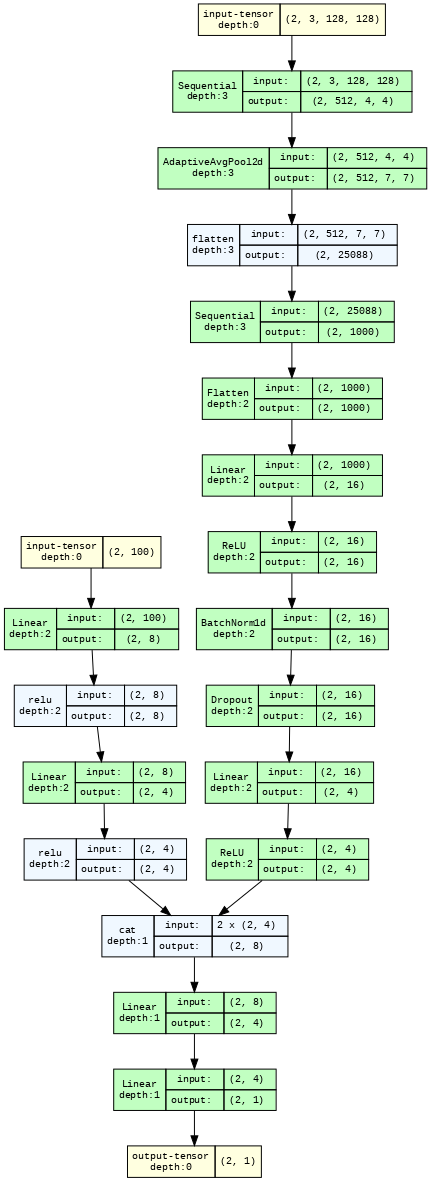

In [ ]:
model_graph = draw_graph(model, [mlp_input, cnn_input])
model_graph.visual_graph

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the CNN module
class CNNModule(nn.Module):
    def __init__(self, input_shape):
        super(CNNModule, self).__init__()

        # Define the VGG16 backbone
        self.backbone = torchvision.models.vgg16(pretrained=True)
        self.backbone.features[0] = nn.Conv2d(input_shape, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Remove fully connected layers
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Additional layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 2 * 2, 16)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        return x


# Define the combined model
class CombinedModel(nn.Module):
    def __init__(self, input_shapes, regress=False):
        super(CombinedModel, self).__init__()

        # Create CNN module
        self.cnn_module = CNNModule(input_shapes[0])

        # MLP layers
        self.fc_mlp1 = nn.Linear(16, 4)
        self.fc_mlp2 = nn.Linear(4, 1) if regress else None

        # Concatenate input from MLP and CNN
        self.concat = torch.cat

    def forward(self, inputs):
        # Forward pass through CNN module
        cnn_output = [self.cnn_module(input_) for input_ in inputs]

        # Concatenate CNN outputs
        x = torch.cat(cnn_output, dim=1)

        # MLP layers
        x = self.fc_mlp1(x)
        x = F.relu(x)

        if self.fc_mlp2:
            x = self.fc_mlp2(x)

        return x


# Input shapes
input_shapes = (3, 64, 64)

# Create model instances
cnn_model = CombinedModel(input_shapes)

# Print the model architecture
print(cnn_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CombinedModel(
  (cnn_module): CNNModule(
    (backbone): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stri

#Exercise 5


In [ ]:
#Possible implementation of the base model which converts an image into a vector of size 128

import torch.nn.functional as F

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(4608, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x




In [ ]:
# Assuming input size is (batch_size, channels, height, width)
input_size = (1, 3, 64, 64)  # Example input size
input_tensor_1 = torch.randn(input_size)  # Example input tensor 1
input_tensor_2 = torch.randn(input_size)  # Example input tensor 2

# Create base model
base_model = BaseModel()

# Now generate embeddings using the same base_model (weight sharing)
f_img_1 = base_model(input_tensor_1)
f_img_2 = base_model(input_tensor_2)

print(f_img_1.shape)
print(f_img_2.shape)


torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
# Define custom layer with distance function
class SquaredEuclidean(nn.Module):
    def forward(self, x, y):
        return torch.sum((x - y)**2, dim=-1)


# Now put everything together
# Define the model
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()
        self.squared_euclidean = SquaredEuclidean()


    def forward(self, img_1, img_2):
        # Apply the custom layer
        dist = self.squared_euclidean(img_1, img_2)
        return dist

# Create an instance of the SiameseModel
siamese = SiameseModel()

# Display the summary
print(siamese)


SiameseModel(
  (squared_euclidean): SquaredEuclidean()
)


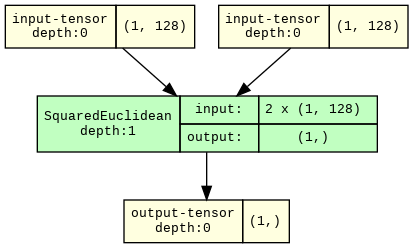

In [ ]:
model_graph = draw_graph(siamese, [f_img_1,f_img_2])
model_graph.visual_graph